In [1]:
%pylab inline
from pathlib import Path

import numpy as np
import time
import tqdm
import torch
import shutil
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomVerticalFlip, RandomHorizontalFlip
from torchvision.transforms import ColorJitter, ToTensor, Normalize


FRUIT360_PATH = Path(".").resolve().parent / "input" / "fruits-360_dataset" / "fruits-360"

img_size = 64

device = "cuda"
if not torch.cuda.is_available():
    device = "cpu"

train_transform = Compose([
    RandomHorizontalFlip(),    
    RandomResizedCrop(size=img_size),
    ColorJitter(brightness=0.12),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = Compose([
    RandomResizedCrop(size=img_size),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 128
num_workers = 10

train_dataset = ImageFolder((FRUIT360_PATH /"Training").as_posix(), transform=train_transform, target_transform=None)
val_dataset = ImageFolder((FRUIT360_PATH /"Test").as_posix(), transform=val_transform, target_transform=None)

pin_memory = "cuda" in device
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                          drop_last=True, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                        drop_last=False, pin_memory=pin_memory)


Populating the interactive namespace from numpy and matplotlib


In [2]:
b = iter(val_loader).next()

In [3]:
data, labels = b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0,60,'Apple Red Delicious')

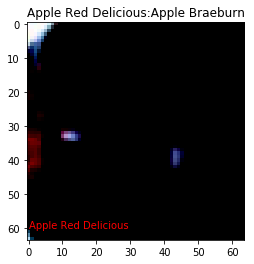

In [4]:
imshow(data[0].numpy().transpose(1, 2, 0))
predictions=[0]*len(labels)
title("{}:{}".format(val_dataset.classes[labels[0]], val_dataset.classes[predictions[0]]));
text(0, 60, val_dataset.classes[labels[0]], color='r')

In [5]:
def show_batch(images, targets, predictions=None):
    ncols = 5 #ceil(sqrt(len(images)))
    nrows = 5 #ceil(len(images)/ncols)
    for i in range(25): #len(images)):
        subplot(nrows, ncols, i+1)
        imshow(data[i].numpy().transpose())
        text(0, 60, val_dataset.classes[labels[i]], color='brown')
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()), fontsize='70')
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

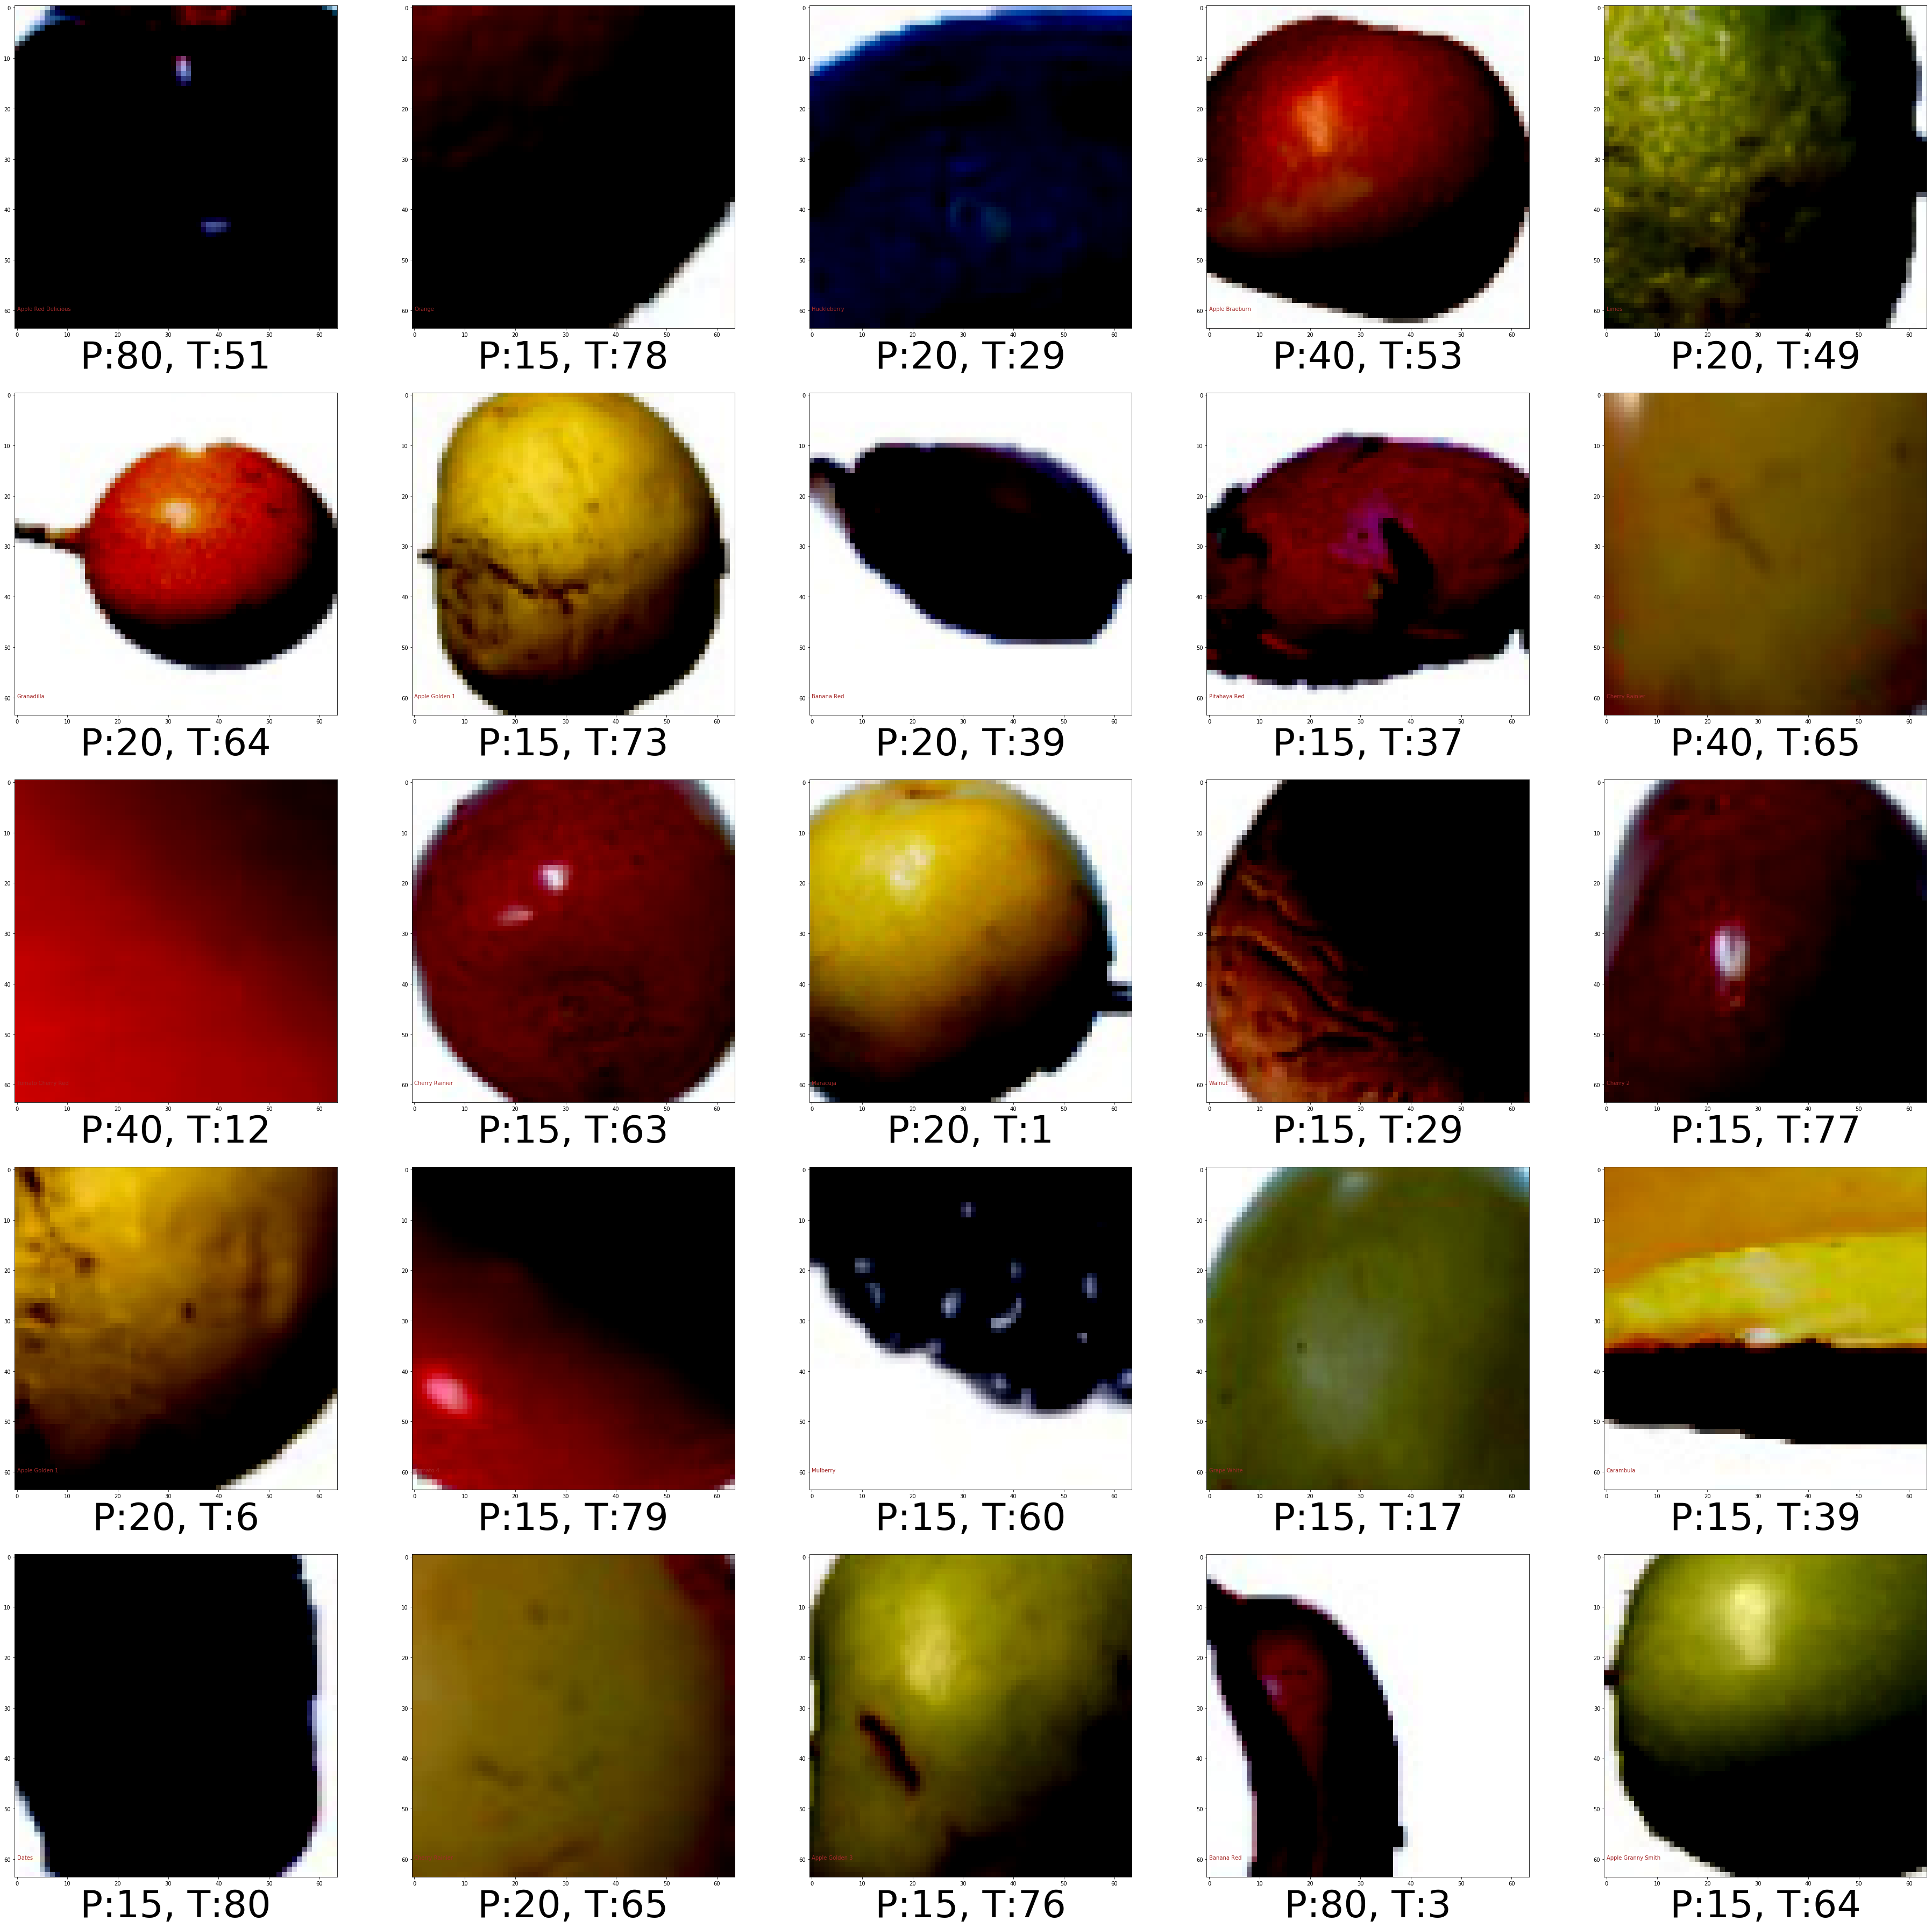

In [11]:
figsize(64,64)
eval_data, eval_target = iter(val_loader).next()
show_batch(eval_data, eval_target, model(eval_data.cuda()).cpu().detach().argmax(1))

In [8]:
print("PyTorch version: {} | Device: {}".format(torch.__version__, device))
print("Train loader: num_batches={} | num_samples={}".format(len(train_loader), len(train_loader.sampler)))
print("Validation loader: num_batches={} | num_samples={}".format(len(val_loader), len(val_loader.sampler)))

PyTorch version: 0.4.1 | Device: cuda
Train loader: num_batches=322 | num_samples=41322
Validation loader: num_batches=109 | num_samples=13877


In [9]:
import torch.nn as nn
from torchvision.models.squeezenet import squeezenet1_1
from torch.optim import SGD


In [10]:
model = squeezenet1_1(pretrained=False, num_classes=81)
model.classifier[-1] = nn.AdaptiveAvgPool2d(1)
model = model.to(device)

C:\Users\zjd19\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\zjd19\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [10]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [11]:
start_epoch = 0
num_epochs = 30
best_epoch = 0
best_eval_loss = float('inf')

In [12]:
def compute_eval_loss(net, loader):
    # Evaluate the model
    with torch.no_grad():
        eval_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(loader),
                                 file = sys.stdout,
                                 desc='Evaluating',
                                 total=len(loader),
                                 leave=False):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)               # Predict
            loss = criterion(outputs, labels)   # Grade / Evaluate
            eval_loss += loss.item()
    eval_loss /= len(val_loader)
    return eval_loss

In [13]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(model, val_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=model.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'simplecnn-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('simplecnn-checkpoint.pth.tar', 'simplecnn-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Epoch    0   loss:  3.96316  test-loss:  3.7227  time: 56.166820764541626                                              
Epoch    1   loss:  2.82177  test-loss:  2.377  time: 52.64324927330017                                                
Epoch    2   loss:  2.19485  test-loss:  1.5989  time: 55.96835160255432                                               
Epoch    3   loss:  1.68173  test-loss:  1.7086  time: 53.53603935241699                                               
Epoch    4   loss:  1.35460  test-loss:  1.172  time: 53.353344202041626                                               
Epoch    5   loss:  1.03297  test-loss:  0.84629  time: 54.67730760574341                                              
Epoch    6   loss:  0.79280  test-loss:  0.73239  time: 55.63413882255554                                              
Epoch    7   loss:  0.66034  test-loss:  0.62005  time: 51.82642364501953                                              
Epoch    8   loss:  0.59902  test-loss: 

In [14]:
predictions = np.zeros(len(val_dataset))
targets = np.zeros(len(val_dataset))

for i  in tqdm.tnrange(len(val_dataset)):
    x, t = val_dataset[i]
    p = model(x[None,...].cuda()).cpu().argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

In [15]:
print(classification_report(targets, predictions, digits=3))

             precision    recall  f1-score   support

        0.0      0.572     0.750     0.649       164
        1.0      1.000     0.915     0.955       164
        2.0      0.958     0.841     0.896       164
        3.0      0.781     0.888     0.831       161
        4.0      0.895     0.988     0.939       164
        5.0      0.813     0.744     0.777       164
        6.0      0.862     0.799     0.829       164
        7.0      0.796     0.896     0.843       144
        8.0      0.965     0.994     0.979       166
        9.0      0.841     0.933     0.884       164
       10.0      0.981     0.957     0.969       164
       11.0      1.000     0.993     0.996       143
       12.0      0.971     0.994     0.982       166
       13.0      0.936     0.970     0.953       166
       14.0      0.917     0.867     0.892       166
       15.0      0.970     0.958     0.964       166
       16.0      0.927     0.933     0.930       164
       17.0      0.994     0.951     0.972   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

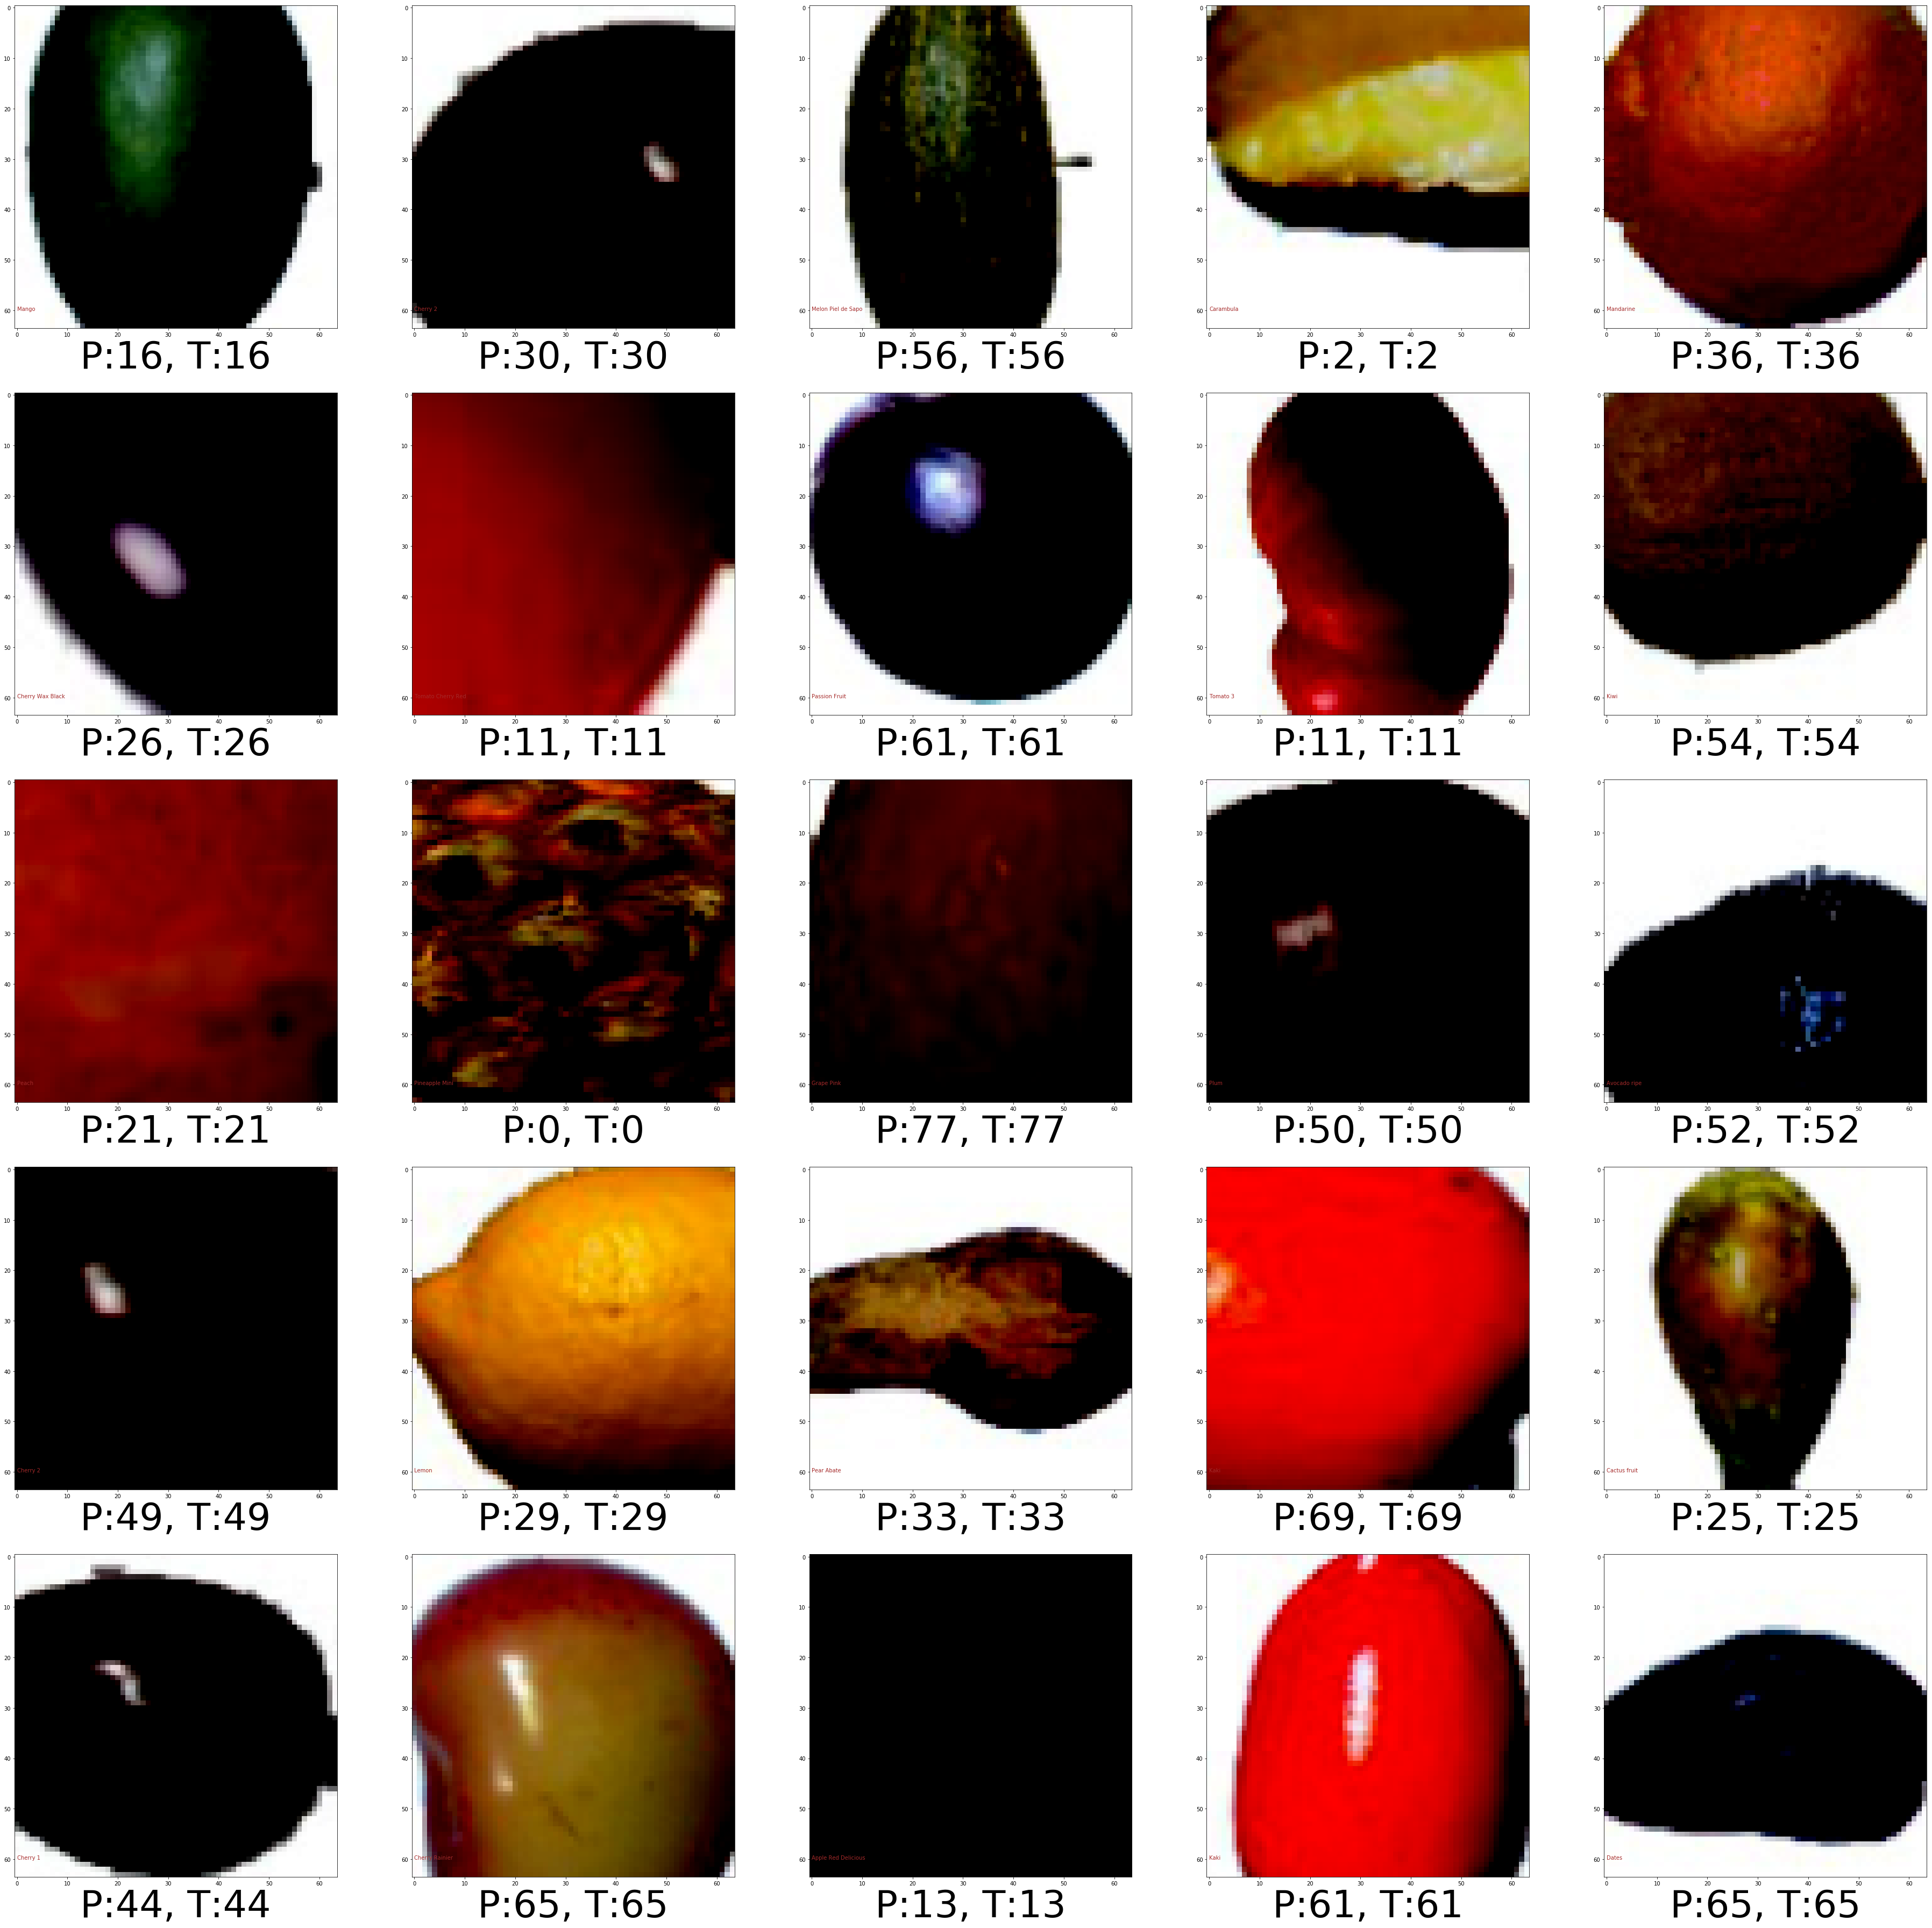

In [48]:
eval_data, eval_target = iter(val_loader).next()
show_batch(eval_data, eval_target, model(eval_data.cuda()).cpu().detach().argmax(1))